# Projet 3A SN :  Détection d'activité humaine - Apprentissage supervisé et non supervisé

**Nom du Groupe :**

**Noms :** BERJON

**Prénoms :** Pierre



Dans ce projet, nous essaierons de prédire l'activité humaine (1-Descendre, 2-Courir, 3-Assis, 4-Debout, 5-Monter ou 6-Marcher) en utilisant les capteurs du smartphone. C'est-à-dire qu'en utilisant les méthodes suivantes, le smartphone peut détecter ce que nous faisons en ce moment.


En utilisant l'accéléromètre  intégré dans le smartphone,  l'accélération linéaire 3-axes à un taux constant de 50Hz ont été relevées. Les expériences ont été enregistrées sur vidéo pour étiqueter les données manuellement. 

<img src="files/HARDataset.JPG" width="800" height="600"  >

Il est fourni pour chaque enregistrement de l'ensemble de données : 
- L'accélération triaxiale de l'accéléromètre (accélération totale)
- Son étiquette d'activité. 
- Un identifiant du sujet qui a réalisé l'expérience.


Ces 5 séances se décomposent en 4 parties : 
- Partie I : Implémenter la DTW pour créer un système de reconnaissance;
- Partie II : Réduction de dimension par ACP et classification par kppv 
- Partie III : Classification par Forêts aléatoires
- Partie IV : Classification par réseaux de neurones
- Partie V : Votre étude

**Travail à rendre**

Pour cela, vous devez par binômes (effectif **OBLIGATOIRE**):
1. Implémenter la DTW pour créer un système de reconnaissance;
2. Evaluer les résultats en utilisant la matrice de confusion et le pourcentage de bonne classification;
3. Réduction de dimension par ACP et classification par kppv 
4. Classification par Forêts aléatoires
5. Classification par réseaux de neurones
6. Rédiger un rapport en pdf présentant votre étude : les résultats par  méthode et vos commentaires et conclusions sur une étude plus générale en modifiant les tailles des ensembles de test et d'apprentissage, en changeant le nombre de classes  (Longeur max. : 10 pages).


**Dataset et description :**
https://archive.ics.uci.edu/ml/datasets/WISDM+Smartphone+and+Smartwatch+Activity+and+Biometrics+Dataset+





In [33]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import pandas as pd
import math
from scipy import stats
import seaborn as sns

In [34]:
COLUMN_NAMES = [
    'user',
    'activity',
    'timestamp',
    'x-axis',
    'y-axis',
    'z-axis'
]

LABELS = [
    'Downstairs',
    'Jogging',
    'Sitting',
    'Standing',
    'Upstairs',
    'Walking'
]

DATA_PATH = './WISDM_ar_v1.1_raw.txt'


# Data preprocessing
TIME_STEP = 60

# Model
N_CLASSES = 3
N_FEATURES = 3  # x-acceleration, y-acceleration, z-acceleration
SEGMENT_TIME_SIZE = 30
TAILLE_TEST=40
TAILLE_APP=20

## 1. Création des données d'apprentissage et de test

Convoluted data shape:  (8376, 30, 3)
Labels shape: (8376,)
Classe N° 0
Classe N° 1
Classe N° 2


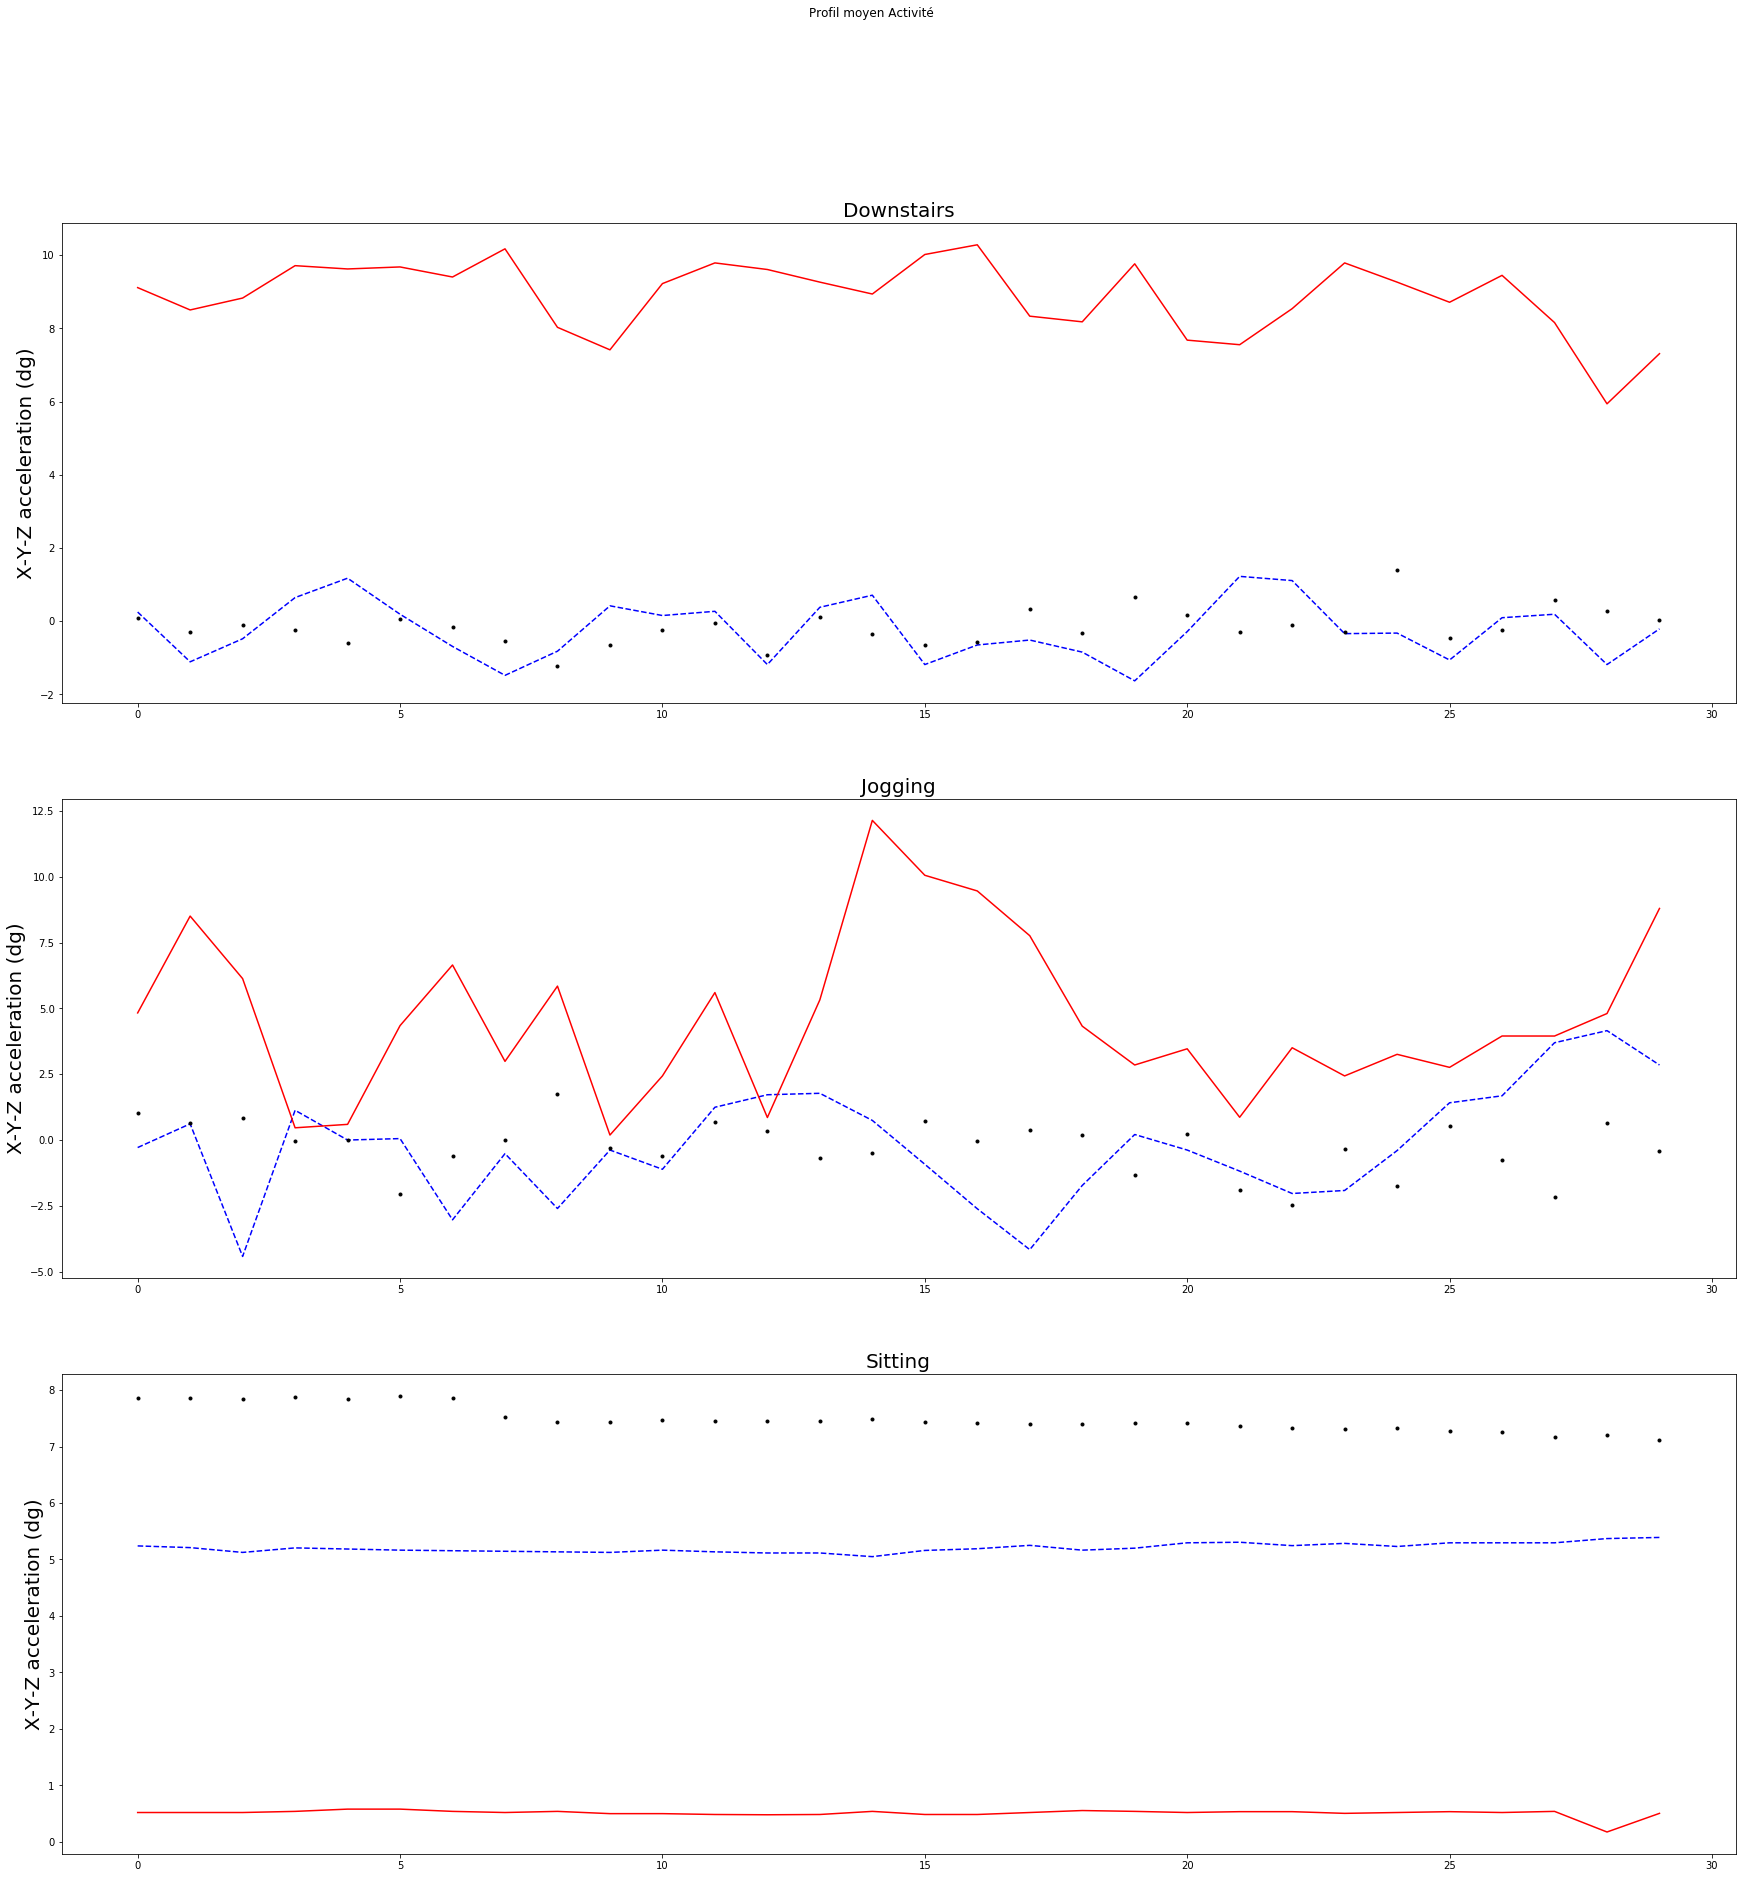

In [35]:
# Chargement DATA
data = pd.read_csv(DATA_PATH, header=None, names=COLUMN_NAMES)
data['z-axis'].replace({';': ''}, regex=True, inplace=True)
data = data.dropna()


data_convoluted = []
labels = []



# Prendre des segments temporels de taille SEGMENT_TIME_SIZE 
# tous les TIME_STEP pour une même activité
for j in range(0,N_CLASSES):
    DataBest=data[data['activity'] == LABELS[j]]
    for i in range(0, len(DataBest) - SEGMENT_TIME_SIZE, TIME_STEP):
        x = DataBest['x-axis'].values[i: i + SEGMENT_TIME_SIZE]
        y = DataBest['y-axis'].values[i: i + SEGMENT_TIME_SIZE]
        z = DataBest['z-axis'].values[i: i + SEGMENT_TIME_SIZE]
        data_convoluted.append([x, y, z])
    # Label de l'activité associée à chaque segment
        label = j
        labels.append(label)


# Conversion numpy
data_convoluted = np.asarray(data_convoluted, dtype=np.float32).transpose(0, 2, 1)

labels = np.asarray(labels, dtype=np.int)
print("Convoluted data shape: ", data_convoluted.shape)
print("Labels shape:", labels.shape)


fig, axs = plt.subplots(N_CLASSES,figsize=(30,30))
fig.suptitle('Profil moyen Activité')

profil_median=np.zeros((N_CLASSES,SEGMENT_TIME_SIZE,N_FEATURES))
List_Data_Test=np.zeros(N_CLASSES*TAILLE_TEST)
Data_Test=np.zeros((N_CLASSES*TAILLE_TEST,SEGMENT_TIME_SIZE*N_FEATURES))
Data_App=np.zeros((TAILLE_APP*N_CLASSES,SEGMENT_TIME_SIZE*N_FEATURES))
Label_Test=np.zeros(N_CLASSES*TAILLE_TEST)
Label_App=np.zeros(N_CLASSES*TAILLE_APP)

for i in range(N_CLASSES):
    # Selection des données correspondant à la classe i
    print('Classe N°',i)
    res=np.where(labels==i)
    res=np.array(res)
    res=np.ravel(res)
    taille=res.shape[0]
    
    # Création de la base de Test
    tirage=np.random.randint(0,taille,TAILLE_TEST)
    List_Data_Test[i*TAILLE_TEST:(i+1)*TAILLE_TEST]=res[tirage[0:TAILLE_TEST]]
    Label_Test[i*TAILLE_TEST:(i+1)*TAILLE_TEST]=i
    tir_dataTest=data_convoluted[res[tirage[0:TAILLE_TEST]],:,:]
    Data_Test[i*TAILLE_TEST:(i+1)*TAILLE_TEST,:]=np.reshape(tir_dataTest,(TAILLE_TEST,SEGMENT_TIME_SIZE*N_FEATURES))
    
    
    # Création de la base d'Apprentissage
    tirage1=np.random.randint(0,taille,TAILLE_APP)
    tir_dataApp=data_convoluted[res[tirage1[0:TAILLE_APP]],:,:]
    Data_App[i*TAILLE_APP:(i+1)*TAILLE_APP,:]=np.reshape(tir_dataApp,(TAILLE_APP,SEGMENT_TIME_SIZE*N_FEATURES))
    Label_App[i*TAILLE_APP:(i+1)*TAILLE_APP]=i
    
    # Affichage du profil temporel moyen de la classe
    class1=np.median(tir_dataApp,axis=0)
    profil_median[i,:,:]=class1
    
    axs[i].plot(range(SEGMENT_TIME_SIZE),class1[:,0],'b--')
    axs[i].plot(range(SEGMENT_TIME_SIZE),class1[:,1],'r-')
    axs[i].plot(range(SEGMENT_TIME_SIZE),class1[:,2],'k.')
    axs[i].set_ylabel('X-Y-Z acceleration (dg)',fontsize=20)
    axs[i].set_title(LABELS[i], fontsize=20)




# Partie I : Implémentation de l'algorithme de programmation dynamique 

1. Ecrivez une fonction en python DTW qui implémente le calcul et l'affichage de la matrice des coûts définie en CTD. 

In [36]:
def dist(p1,p2):
    return (p1-p2)**2

def DTW_Matrix(A,B):
    M = len(A) # longueur de la première série
    N = len(B) # longueur de la deuxième série
    g = np.zeros((N,M),dtype=float) # initialisation de la matrice DTW
    
    for i in range(1,M):
        g[0,i] = dist(A[i],B[0]) + g[0,i-1]
    for i in range(1,N):
        g[i,0] = dist(A[0],B[i]) + g[i-1,0]
    for i in range(1,N):
        for j in range(1,M):
            cost = dist(A[j],B[i])
            g[i,j] = np.min([g[i-1,j] + cost, g[i,j-1] + cost, g[i-1,j-1] + 2*cost])
    
    return g

def DTW_Score(A,B):
    M = len(A)
    N = len(B)
    g = DTW_Matrix(A,B)
    
    S = g[N-1,M-1]/(N+M)
    return S
    
#DTW_Matrix(np.cos(2*np.pi*(3*np.arange(1,1001,dtype=float)/1000)**2),np.cos(2*np.pi*9*np.arange(1,400,dtype=float)/400))

2. Pour chaque profil temporel test :

a) Calculer pour chaque classe, le score de la DTW entre le profil temporel test et les profils temporels de la classe 

b) Déterminer la classe d'appartenance par minimum du score sur toutes les classes




In [37]:
list_Classes = []
for i in range(Data_Test.shape[0]):
    scoreClass1 = DTW_Score(Data_Test[i], profil_median[0,:,:].reshape(-1))
    scoreClass2 = DTW_Score(Data_Test[i].reshape(-1), profil_median[1,:,:].reshape(-1))
    scoreClass3 = DTW_Score(Data_Test[i].reshape(-1), profil_median[2,:,:].reshape(-1))
        
    scores = [scoreClass1,scoreClass2,scoreClass3]
    list_Classes.append(scores.index(min(scores)))
    

3. A partir de la partition de l'ensemble test obtenue après la DTW, calculer la matrice de confusion qui recense le nombre de données bien classés et mal classés.

In [38]:
from sklearn.metrics import confusion_matrix

cm_DTW = confusion_matrix(list_Classes, Label_Test)
rate_DTW = (cm_DTW[0,0] + cm_DTW[1,1] + cm_DTW[2,2])/(Data_Test.shape[0])
print(cm_DTW, "\nRate with DTW = ", rate_DTW)

[[36 19 26]
 [ 3 21  2]
 [ 1  0 12]] 
Rate with DTW =  0.575


# Partie II : Réduction de dimension par ACP et classification par kppv 

Dans cette partie, nous allons comparer les résultats de la DTW avec ceux d'une méthode de classification de données : les k-plus proches voisins.

Nous utiliserons les fonctions permettant de calculer l'ACP et les kppv via la librairie python *scikit-learn*.




### Prétraitement par ACP

Pour tester une autre méthode de classification, 

1. A partir des données Data_App de la base d'apprentissage et en utilisant la fonction *PCA* de la librairie *scikit-learn*, calculez les 3 axes principaux de l'ACP en
extrayant les 3 vecteurs propres, notés $X_1$, $X_2$, $X_3$, associés aux 3 plus grandes valeurs propres de la matrice de
variance-covariance $\Sigma_{App}$.Ces vecteurs propres constitueront la nouvelle base de données.

2. Projetez les données de la base d'apprentissage et de test dans cette nouvelle base en multipliant chaque
vecteur par la base $P = [X_1X_2X_3]$.

*Remarque :* vous pouvez aussi implémenter l'ACP en
extrayant les 3 vecteurs propres, notés $X_1$, $X_2$, $X_3$, associés aux 3 plus grandes valeurs propres de la matrice de
variance-covariance $\Sigma_{App}$ (par les fonctions *np.cov* et *np.linalg.eig*). Ces vecteurs propres constitueront le nouveau repère P.  Projetez ensuite les données de la base d'apprentissage et de test dans cette nouvelle base en multipliant chaque vecteur par la base $P = [X_1X_2X_3]$.




In [39]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 3)
pca.fit(Data_App)
axes = pca.singular_values_

New_Data_App = np.dot(Data_App.reshape(Data_App.shape[0],Data_App.shape[1]//3,3), axes.transpose())
New_Data_Test = np.dot(Data_Test.reshape(Data_Test.shape[0],Data_Test.shape[1]//3,3), axes.transpose())

### Classification par k plus proches voisins

En intelligence artificielle, la méthode des k plus proches voisins (k-ppv) est une méthode d'apprentissage
supervisé. Dans ce cadre, on dispose d'une base de données d'apprentissage constituée de couples  "donnée-label". Pour estimer la sortie associée à une nouvelle entrée x, la méthode des k plus proches voisins consiste à prendre
en compte (de façon identique) les k échantillons d'apprentissage dont l'entrée est la plus proche de la nouvelle
entrée x, selon une distance à définir. L'algorithme 1 associé et un exemple (figure 1) sont données par la suite.

<img src="files/AlgoKppv.png" width="900" height="800"  >

<img src="files/kppv.png" width="300" height="300"  >

**Exemple de classification par k-ppv.** L'échantillon de test (cercle vert) doit être classé soit dans la première
classe des carrés bleus, soit dans la deuxième classe des triangles rouges. 
Si k = 3 (cercle plein), il est assigné à la deuxième classe parce qu'il y a 2 triangles et seulement 1 carré à l'intérieur du cercle intérieur. 
Si k = 5 (cercle en pointillés), il est assigné à la première classe (3 carrés contre 2 triangles à l'intérieur du cercle extérieur)


1. En utilisant la fonction *KNeighborsClassifier* de la librairie *sklearn.neighbors*, réalisez une classification par k-ppv sur la base d'apprentissage et la base de test que vous avez prédéfinies (prendre $k=1$).

2. Evaluez la méthode des k-ppv par le calcul de la matrice de confusion et du taux de reconnaissance.

3. Modifiez la valeur de $k$ pour les k-ppv. Améliorez-vous les scores de reconnaissance ?

4. Comparez vos résultats avec ceux de la DTW.






In [40]:
from sklearn.neighbors import KNeighborsClassifier

knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(New_Data_App, Label_App)

knn3 = KNeighborsClassifier(n_neighbors=3)
knn3.fit(New_Data_App, Label_App)

knn5 = KNeighborsClassifier(n_neighbors=5)
knn5.fit(New_Data_App, Label_App)

predictions1 = knn1.predict(New_Data_Test)
predictions3 = knn3.predict(New_Data_Test)
predictions5 = knn5.predict(New_Data_Test)

cm1ppv = confusion_matrix(predictions1, Label_Test)
rate1ppv = (cm1ppv[0,0] + cm1ppv[1,1] + cm1ppv[2,2])/(New_Data_Test.shape[0])
cm3ppv = confusion_matrix(predictions3, Label_Test)
rate3ppv = (cm3ppv[0,0] + cm3ppv[1,1] + cm3ppv[2,2])/(New_Data_Test.shape[0])
cm5ppv = confusion_matrix(predictions5, Label_Test)
rate5ppv = (cm5ppv[0,0] + cm5ppv[1,1] + cm5ppv[2,2])/(New_Data_Test.shape[0])

print(cm1ppv, "\nRate with 1 neighbor = ", rate1ppv, "\n")
print(cm3ppv, "\nRate with 3 neighbors = ", rate3ppv, "\n")
print(cm5ppv, "\nRate with 5 neighbors = ", rate5ppv, "\n")

[[11 19  0]
 [ 0 10  1]
 [29 11 39]] 
Rate with 1 neighbor =  0.5 

[[ 7 17  0]
 [ 0  7  0]
 [33 16 40]] 
Rate with 3 neighbors =  0.45 

[[ 1 11  0]
 [ 0  4  0]
 [39 25 40]] 
Rate with 5 neighbors =  0.375 



# Partie III : Classification par Forêts aléatoires

Les forêts aléatoires font partie des techniques d'apprentissage automatique. Cet algorithme combine les concepts de sous-espaces aléatoires et de bagging. L'algorithme des forêts d'arbres décisionnels effectue un apprentissage sur de multiples arbres de décision entraînés sur des sous-ensembles de données légèrement différents.

In [41]:
from sklearn.ensemble import RandomForestClassifier 

clf = RandomForestClassifier()
clf.fit(New_Data_App, Label_App)
preds = clf.predict(New_Data_Test)

cmRFC = confusion_matrix(preds, Label_Test)
rateRFC = (cmRFC[0,0] + cmRFC[1,1] + cmRFC[2,2])/(New_Data_Test.shape[0])
print(cmRFC, "\nRate with a Random Forest =", rateRFC)

[[25 11  5]
 [ 4 29  5]
 [11  0 30]] 
Rate with a Random Forest = 0.7


**Evaluation de la classification**

La performance des forêts aléatoires peut être estimée par : 
- **Accuracy score :** évaluation de la précision c'est-à-dire du nombre de données bien classées.
- **Out-of-bag estimate :**  méthode de mesure de l'erreur de prédiction des forêts aléatoires, des arbres de décision renforcés et d'autres modèles d'apprentissage utilisant l'agrégation bootstrap pour sous-échantillonner les données d'apprentissage. L'OOB est l'erreur moyenne de prédiction sur chaque échantillon d'apprentissage xᵢ, en utilisant uniquement les arbres qui n'avaient pas xᵢ dans leur échantillon bootstrap 




# Partie IV : Classification par réseaux de neurones

1. Réaliser une classification via les réseaux de neurones
2. Evaluer les résultats par matrice de confusion par exemple, fonction de perte...
3. Tester différentes architectures et différentes solveurs

In [42]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state=1, max_iter=300).fit(New_Data_App, Label_App)
predictions_NN = clf.predict(New_Data_Test)

cm_NN = confusion_matrix(predictions_NN, Label_Test)
rate_NN = (cm_NN[0,0] + cm_NN[1,1] + cm_NN[2,2])/(New_Data_Test.shape[0])
print(cm_NN, "\nRate with a Neural Network =", rate_NN)

[[28 20  3]
 [ 4 12  0]
 [ 8  8 37]] 
Rate with a Neural Network = 0.6416666666666667


# Partie V : votre étude

Réalisez votre propre étude en :
- en augmentant les bases de test et/ou d'apprentissage et/ou la durée des segments 
- en proposant des variantes des méthodes proposées ou en utilisant d'autres
- en rajoutant davantage de classes (jusqu'à 3 supplémentaires : 4-Debout, 5-Monter ou 6-Marcher ) 
le tout en testant les différentes approches et en interprétant les résultats, à synthétiser sur un rapport. 




In [43]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import pandas as pd
import math
from scipy import stats
import seaborn as sns

In [44]:
COLUMN_NAMES = [
    'user',
    'activity',
    'timestamp',
    'x-axis',
    'y-axis',
    'z-axis'
]

LABELS = [
    'Downstairs',
    'Jogging',
    'Sitting',
    'Standing',
    'Upstairs',
    'Walking'
]

DATA_PATH = './WISDM_ar_v1.1_raw.txt'


# Data preprocessing
TIME_STEP = 60

## **1. Influence des dimensionnements des données sur le score de reconnaissance**
Ici, nous allons faire varier trois paramètres : 
* **la taille du segment**
* **la taille du jeu de données d'apprentissage**
* **la taille de jeu de données de test**

### **1.1. Pré-traitement de la donnée**

Ensuite, nous déterminerons quelles sont les valeurs optimales pour ces paramètres, que nous utiliserons ensuite.
La fonction qui suit nous permet d'automatiser le traitement des données en faisant varier ses paramètres. Nous avons également pris le parti d'effectuer l'ACP dans celle-ci, afin de ne pas avoir à la refaire ensuite (une fois la fonction *traitement* utilisée, nous avons totalement pré-traité la donnée, nous pouvons directement passer à l'entraînement de nos modèles).

In [45]:
def traitement(N_CLASSES = 3, N_FEATURES = 3, SEGMENT_TIME_SIZE = 30, TAILLE_TEST = 40, TAILLE_APP = 20): # Ici, on va faire varier les paramètres du modèle et étudier leur influence sur les résultats

    # Chargement DATA
    data = pd.read_csv(DATA_PATH, header=None, names=COLUMN_NAMES)
    data['z-axis'].replace({';': ''}, regex=True, inplace=True)
    data = data.dropna()


    data_convoluted = []
    labels = []



    # Prendre des segments temporels de taille SEGMENT_TIME_SIZE 
    # tous les TIME_STEP pour une même activité
    for j in range(0,N_CLASSES):
        DataBest=data[data['activity'] == LABELS[j]]
        for i in range(0, len(DataBest) - SEGMENT_TIME_SIZE, TIME_STEP):
            x = DataBest['x-axis'].values[i: i + SEGMENT_TIME_SIZE]
            y = DataBest['y-axis'].values[i: i + SEGMENT_TIME_SIZE]
            z = DataBest['z-axis'].values[i: i + SEGMENT_TIME_SIZE]
            data_convoluted.append([x, y, z])
        # Label de l'activité associée à chaque segment
            label = j
            labels.append(label)


    # Conversion numpy
    data_convoluted = np.asarray(data_convoluted, dtype=np.float32).transpose(0, 2, 1)

    labels = np.asarray(labels, dtype=np.int)
    #print("Convoluted data shape: ", data_convoluted.shape)
    #print("Labels shape:", labels.shape)


    #fig, axs = plt.subplots(N_CLASSES,figsize=(30,30))
    #fig.suptitle('Profil moyen Activité')

    profil_median=np.zeros((N_CLASSES,SEGMENT_TIME_SIZE,N_FEATURES))
    List_Data_Test=np.zeros(N_CLASSES*TAILLE_TEST)
    Data_Test=np.zeros((N_CLASSES*TAILLE_TEST,SEGMENT_TIME_SIZE*N_FEATURES))
    Data_App=np.zeros((TAILLE_APP*N_CLASSES,SEGMENT_TIME_SIZE*N_FEATURES))
    Label_Test=np.zeros(N_CLASSES*TAILLE_TEST)
    Label_App=np.zeros(N_CLASSES*TAILLE_APP)

    for i in range(N_CLASSES):
        # Selection des données correspondant à la classe i
        #print('Classe N°',i)
        res=np.where(labels==i)
        res=np.array(res)
        res=np.ravel(res)
        taille=res.shape[0]

        # Création de la base de Test
        tirage=np.random.randint(0,taille,TAILLE_TEST)
        List_Data_Test[i*TAILLE_TEST:(i+1)*TAILLE_TEST]=res[tirage[0:TAILLE_TEST]]
        Label_Test[i*TAILLE_TEST:(i+1)*TAILLE_TEST]=i
        tir_dataTest=data_convoluted[res[tirage[0:TAILLE_TEST]],:,:]
        Data_Test[i*TAILLE_TEST:(i+1)*TAILLE_TEST,:]=np.reshape(tir_dataTest,(TAILLE_TEST,SEGMENT_TIME_SIZE*N_FEATURES))


        # Création de la base d'Apprentissage
        tirage1=np.random.randint(0,taille,TAILLE_APP)
        tir_dataApp=data_convoluted[res[tirage1[0:TAILLE_APP]],:,:]
        Data_App[i*TAILLE_APP:(i+1)*TAILLE_APP,:]=np.reshape(tir_dataApp,(TAILLE_APP,SEGMENT_TIME_SIZE*N_FEATURES))
        Label_App[i*TAILLE_APP:(i+1)*TAILLE_APP]=i

        # Affichage du profil temporel moyen de la classe
        class1=np.median(tir_dataApp,axis=0)
        profil_median[i,:,:]=class1

        #axs[i].plot(range(SEGMENT_TIME_SIZE),class1[:,0],'b--')
        #axs[i].plot(range(SEGMENT_TIME_SIZE),class1[:,1],'r-')
        #axs[i].plot(range(SEGMENT_TIME_SIZE),class1[:,2],'k.')
        #axs[i].set_ylabel('X-Y-Z acceleration (dg)',fontsize=20)
        #axs[i].set_title(LABELS[i], fontsize=20)
        
    from sklearn.decomposition import PCA

    pca = PCA(n_components = 3)
    pca.fit(Data_App)
    axes = pca.singular_values_

    New_Data_App = np.dot(Data_App.reshape(Data_App.shape[0],Data_App.shape[1]//3,3), axes.transpose())
    New_Data_Test = np.dot(Data_Test.reshape(Data_Test.shape[0],Data_Test.shape[1]//3,3), axes.transpose())


### 1.2. Définition et entraînement des modèles

Ici, nous définissons les modèles utilisés, les entraînons et déterminons les scores de reconnaissance associés à ceux-ci. Encore une fois, nous passons par des fonctions (*rate_KNN*, *rate_RFC*, et *rate_NN*) pour rendre notre code plus souple.

In [46]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neural_network import MLPClassifier

def rate_KNN(n_neighbors=1, weights='uniform', algorithm='auto'):

    knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, algorithm=algorithm)
    knn.fit(New_Data_App, Label_App)

    predictions = knn.predict(New_Data_Test)

    cm = confusion_matrix(predictions1, Label_Test)
    rate = (cm1ppv[0,0] + cm1ppv[1,1] + cm1ppv[2,2])/(New_Data_Test.shape[0])

    return rate

def rate_RFC(n_estimators=100, criterion='gini', max_depth=None):

    clf = RandomForestClassifier()
    clf.fit(New_Data_App, Label_App)
    preds = clf.predict(New_Data_Test)

    cmRFC = confusion_matrix(preds, Label_Test)
    rateRFC = (cmRFC[0,0] + cmRFC[1,1] + cmRFC[2,2])/(New_Data_Test.shape[0])
    return rateRFC

def rate_NN(activation='relu',solver='adam',max_iter=300):

    clf = MLPClassifier(activation=activation,solver=solver,max_iter=max_iter,random_state=1).fit(New_Data_App, Label_App)
    predictions_NN = clf.predict(New_Data_Test)

    cm_NN = confusion_matrix(predictions_NN, Label_Test)
    rate_NN = (cm_NN[0,0] + cm_NN[1,1] + cm_NN[2,2])/(New_Data_Test.shape[0])
    return rate_NN

### 1.3. Résultats et optimisation des paramètres

Ici, nous en arrivons au stade où nous pouvons observer l'influence des paramètres sur l'efficacité de nos modèles. On utilisera des dictionnaires pour stocker les scores de reconnaissance associés aux trois modèles utilisés, et ce pour chaque paramètre modifié.

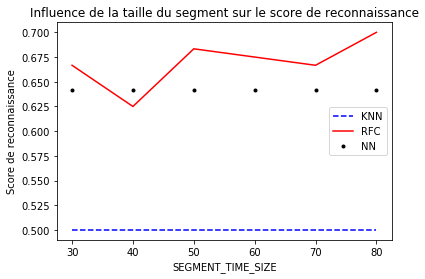

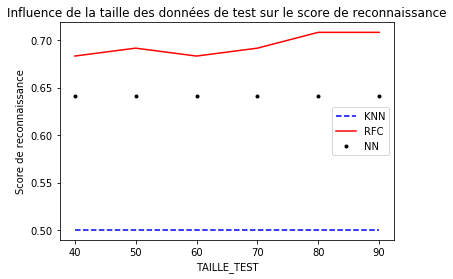

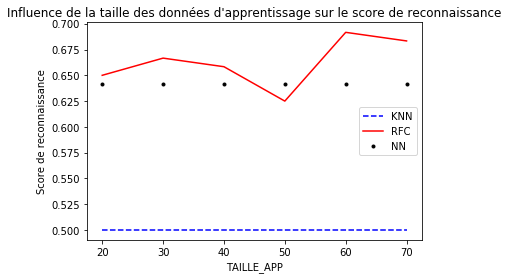

In [47]:
## Traitement : variation des paramètres

from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Model
#N_CLASSES = 3
#N_FEATURES = 3  # x-acceleration, y-acceleration, z-acceleration
#SEGMENT_TIME_SIZE = 30
#TAILLE_TEST=40
#TAILLE_APP=20

models = ["KNN", "RFC", "NN"]
N_MODELES = len(models) # nombre de modèles utilisés (KNN, RFC, etc...)

def comparaison_SEGMENT_SIZE():
    
    rates_KNN = {}
    rates_RFC = {}
    rates_NN = {}
    
    for i in range(6):
        traitement(SEGMENT_TIME_SIZE = 30 + 10*i)
        rates_KNN[str(30 + 10*i)] = rate_KNN()
        rates_RFC[str(30 + 10*i)] = rate_RFC()
        rates_NN[str(30 + 10*i)] = rate_NN()

    list_KNN = sorted(rates_KNN.items())
    list_RFC = sorted(rates_RFC.items())
    list_NN = sorted(rates_NN.items())
    x_KNN, y_KNN = zip(*list_KNN)
    x_RFC, y_RFC = zip(*list_RFC)
    x_NN, y_NN = zip(*list_NN)

    plt.plot(x_KNN,y_KNN,'b--',label="KNN")
    plt.plot(x_RFC,y_RFC,'r-',label="RFC")
    plt.plot(x_NN,y_NN,'k.',label="NN")

    plt.title('Influence de la taille du segment sur le score de reconnaissance')
    plt.xlabel("SEGMENT_TIME_SIZE")
    plt.ylabel("Score de reconnaissance")
    plt.legend()
    plt.show()
    
def comparaison_TAILLE_TEST():
    
    rates_KNN = {}
    rates_RFC = {}
    rates_NN = {}
    
    for i in range(6):
        traitement(TAILLE_TEST = 40 + 10*i)
        rates_KNN[str(40 + 10*i)] = rate_KNN()
        rates_RFC[str(40 + 10*i)] = rate_RFC()
        rates_NN[str(40 + 10*i)] = rate_NN()

    list_KNN = sorted(rates_KNN.items())
    list_RFC = sorted(rates_RFC.items())
    list_NN = sorted(rates_NN.items())
    x_KNN, y_KNN = zip(*list_KNN)
    x_RFC, y_RFC = zip(*list_RFC)
    x_NN, y_NN = zip(*list_NN)

    plt.plot(x_KNN,y_KNN,'b--',label="KNN")
    plt.plot(x_RFC,y_RFC,'r-',label="RFC")
    plt.plot(x_NN,y_NN,'k.',label="NN")

    plt.title('Influence de la taille des données de test sur le score de reconnaissance')
    plt.xlabel("TAILLE_TEST")
    plt.ylabel("Score de reconnaissance")
    plt.legend()
    plt.show()
    
def comparaison_TAILLE_APP():
    
    rates_KNN = {}
    rates_RFC = {}
    rates_NN = {}
    
    for i in range(6):
        traitement(TAILLE_APP = 20 + 10*i)
        rates_KNN[str(20 + 10*i)] = rate_KNN()
        rates_RFC[str(20 + 10*i)] = rate_RFC()
        rates_NN[str(20 + 10*i)] = rate_NN()

    list_KNN = sorted(rates_KNN.items())
    list_RFC = sorted(rates_RFC.items())
    list_NN = sorted(rates_NN.items())
    x_KNN, y_KNN = zip(*list_KNN)
    x_RFC, y_RFC = zip(*list_RFC)
    x_NN, y_NN = zip(*list_NN)

    plt.plot(x_KNN,y_KNN,'b--',label="KNN")
    plt.plot(x_RFC,y_RFC,'r-',label="RFC")
    plt.plot(x_NN,y_NN,'k.',label="NN")

    plt.title("Influence de la taille des données d'apprentissage sur le score de reconnaissance")
    plt.xlabel("TAILLE_APP")
    plt.ylabel("Score de reconnaissance")
    plt.legend()
    plt.show()
    
def comparaison_globale():
    
    rates_KNN = {}
    rates_RFC = {}
    rates_NN = {}
    
    for i in range(6):
        time_size = 30 + 10*i
        for j in range(6):
            taille_test = 40 + 10*i
            for k in range(6):
                taille_app = 20 + 10*i
                traitement(SEGMENT_TIME_SIZE = time_size, TAILLE_TEST = taille_test, TAILLE_APP = taille_app)
                rates_KNN["TS = " + str(30 + 10*i) + ", TT = " + str(40 + 10*j) + ", TA = " + str(20 + 10*k)] = rate_KNN()
                rates_RFC["TS = " + str(30 + 10*i) + ", TT = " + str(40 + 10*j) + ", TA = " + str(20 + 10*k)] = rate_RFC()
                rates_NN["TS = " + str(30 + 10*i) + ", TT = " + str(40 + 10*j) + ", TA = " + str(20 + 10*k)] = rate_NN()
                print(rates_RFC)
    
    print(rates_RFC)
    print(rates_KNN)
    print(rates_NN)
    
    
    
    
comparaison_SEGMENT_SIZE()
comparaison_TAILLE_TEST()
comparaison_TAILLE_APP()
#comparaison_globale()

On voit bien ici que tous ces paramètres n'ont aucun impact sur le score de reconnaissance pour KNN et le réseau de neurones utilisé. Cependant, ils en tous une sur le classifieur Random Forest. Dans ces conditions, on constate que nous avons un intérêt certain à augmenter chacun de ces paramètres. 

Cependant, on ne peut pas représenter tenir compte graphiquement des valeurs optimales pour les trois paramètres, car nous les obtiendrions en faisant varier les 3 paramètres en même temps.

C'est donc avec la fonction *comparaison_globale* que nous réglons cette question, et les valeurs optimales obtenues sont alors :

* SEGMENT\_SIZE = 30

* TAILLE\_TEST = 80

* TAILLE\_APP = 40

Pour ces valeurs, le score de reconnaissance atteint $0.816$.
**Attention**, il est très déconseillé de lancer *comparaison_globale*, la complexité de cette fonction étant catastrophique.

In [48]:
SEGMENT_SIZE,TAILLE_TEST,TAILLE_APP = 30,80,40 # initialisation pour les valeurs optimales

## 2. Analyse détaillée des différents modèles utilisés

Ici, nous allons tenter d'optimiser les différents modèles utilisés et d'en distinguer le plus efficace.

### 2.1. Random Forest Classifiers

Nous limiterons ici notre étude sur le **nombre d'estimateurs** (*n_estimators*), le **critère de segmentation** (*criterion*) à utiliser, et la **profondeur maximale** de l'arbre (*max_depth*).

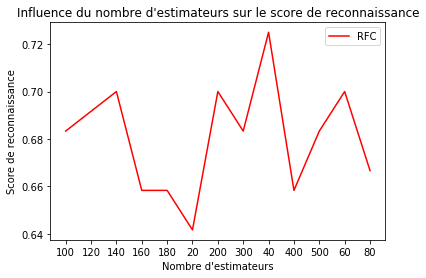

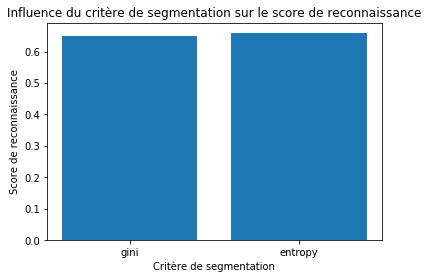

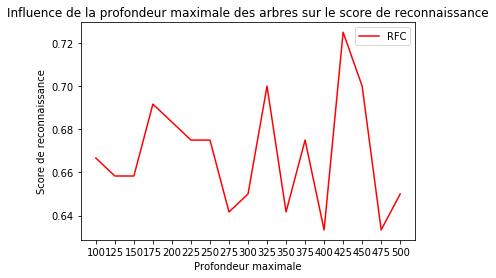

In [49]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix

list_estimators = [20,40,60,80,100,120,140,160,180,200,300,400,500]
list_criterions = ['gini','entropy']
list_depths = range(100,501,25)

def comparaison_ESTIMATORS():
    
    rates_RFC = {}
    
    for n in list_estimators:
        rates_RFC[str(n)] = rate_RFC(n_estimators = n)

    list_RFC = sorted(rates_RFC.items())
    x_RFC, y_RFC = zip(*list_RFC)

    plt.plot(x_RFC,y_RFC,'r-',label="RFC")

    plt.title("Influence du nombre d'estimateurs sur le score de reconnaissance")
    plt.xlabel("Nombre d'estimateurs")
    plt.ylabel("Score de reconnaissance")
    plt.legend()
    plt.show()

def comparaison_CRITERIONS():
    
    rates_RFC = {}
    
    for criterion in list_criterions:
        rates_RFC[criterion] = rate_RFC(criterion = criterion)

    names = list(rates_RFC.keys())
    values = list(rates_RFC.values())

    plt.bar(names,values)

    plt.title("Influence du critère de segmentation sur le score de reconnaissance")
    plt.xlabel("Critère de segmentation")
    plt.ylabel("Score de reconnaissance")
    plt.show()
    
def comparaison_DEPTHS():
    
    rates_RFC = {}
    
    for depth in list_depths:
        rates_RFC[str(depth)] = rate_RFC(max_depth = depth)

    list_RFC = sorted(rates_RFC.items())
    x_RFC, y_RFC = zip(*list_RFC)

    plt.plot(x_RFC,y_RFC,'r-',label="RFC")

    plt.title("Influence de la profondeur maximale des arbres sur le score de reconnaissance")
    plt.xlabel("Profondeur maximale")
    plt.ylabel("Score de reconnaissance")
    plt.legend()
    plt.show()
    
def analyse_conjointe():
    
    rates_RFC = {}
    
    for n in list_estimators:
        for criterion in list_criterions:
            for depth in list_depths:
                rates_RFC["n_estimators = " + str(n) + ", criterion = " + criterion + ", max_depth = " + str(depth)] = rate_RFC(n_estimators = n, criterion = criterion, max_depth = depth)
                rates_RFC = {k: v for k, v in sorted(rates_RFC.items(), key=lambda item: item[1])} # on trie rates_RFC par valeur
    print(list(rates_RFC.keys())[-1], "score = ", list(rates_RFC.values())[-1]) # on renvoie le dernier élément (celui-ci qui maximise le score de reconnaissance)

comparaison_ESTIMATORS()
comparaison_CRITERIONS()
comparaison_DEPTHS()
#analyse_conjointe()

De la même façon que pour la section précédente, on peut déterminer des valeurs optimales pour un paramètre précis (en gardant les autres paramètres par défaut) qui optimiseraient le score de reconnaissance de notre modèle. Ici, ce serait : 

* n_estimators = 140

* criterion = 'gini' (on prend celui-ci car en moyenne on voit qu'il est meilleur, mais la différence est extrêmement faible)

* max_depth = 125

Cependant, on effectue une analyse conjointe avec *analyse_conjointe* et on obtient le valeurs suivantes :

* n_estimators = 140

* criterion = 'entropy' (on prend celui-ci car en moyenne on voit qu'il est meilleur, mais la différence est extrêmement faible)

* max_depth = 325

Avec ces valeurs, on obtient un score de reconnaissance de $0.825$.  On a bien amélioré le modèle, ce sont ces valeurs que nous retiendrons.


### 2.2. K-Nearest Neighbors

Nous limiterons ici notre étude sur le **nombre de voisins** (*n_neighbors*), la **fonction de poids** (*weights*) à utiliser, et l'**algorithme utilisé pour calculer les voisins les plus proches** (*algorithm*).


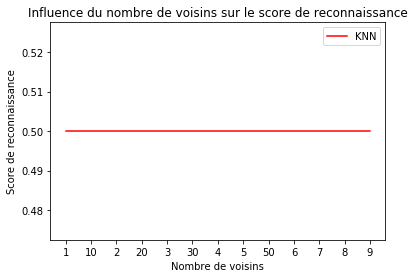

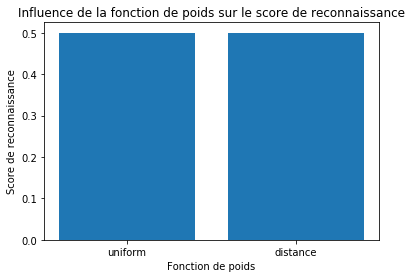

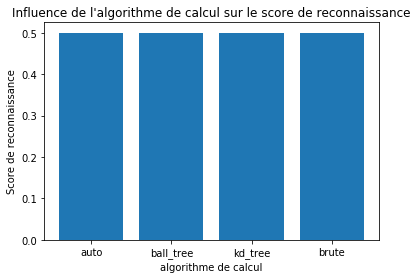

In [50]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix

list_neighbors = [1,2,3,4,5,6,7,8,9,10,20,30,50]
list_weights = ['uniform', 'distance']
list_algorithms = ['auto', 'ball_tree', 'kd_tree', 'brute']

def comparaison_NEIGHBORS():
    
    rates_KNN = {}
    
    for n in list_neighbors:
        rates_KNN[str(n)] = rate_KNN(n_neighbors = n)

    list_KNN = sorted(rates_KNN.items())
    x_KNN, y_KNN = zip(*list_KNN)

    plt.plot(x_KNN,y_KNN,'r-',label="KNN")

    plt.title("Influence du nombre de voisins sur le score de reconnaissance")
    plt.xlabel("Nombre de voisins")
    plt.ylabel("Score de reconnaissance")
    plt.legend()
    plt.show()

def comparaison_WEIGHTS():
    
    rates_KNN = {}
    
    for weight in list_weights:
        rates_KNN[weight] = rate_KNN(weights = weight)

    names = list(rates_KNN.keys())
    values = list(rates_KNN.values())

    plt.bar(names,values)

    plt.title("Influence de la fonction de poids sur le score de reconnaissance")
    plt.xlabel("Fonction de poids")
    plt.ylabel("Score de reconnaissance")
    plt.show()
    
def comparaison_ALGORITHMS():
    
    rates_KNN = {}
    
    for algo in list_algorithms:
        rates_KNN[str(algo)] = rate_KNN(algorithm = algo)

    names = list(rates_KNN.keys())
    values = list(rates_KNN.values())

    plt.bar(names,values)

    plt.title("Influence de l'algorithme de calcul sur le score de reconnaissance")
    plt.xlabel("algorithme de calcul")
    plt.ylabel("Score de reconnaissance")
    plt.show()
    
def analyse_conjointe():
    
    rates_KNN = {}
    for i in range(5):
        for n in list_neighbors:
            for weight in list_weights:
                for algo in list_algorithms:
                    rates_KNN["n_neighbors = " + str(n) + ", weights = " + weight + ", algorithm = " + algo] = rate_KNN(n_neighbors = n, weights = weight, algorithm = algo)
                    rates_KNN = {k: v for k, v in sorted(rates_KNN.items(), key=lambda item: item[1])} # on trie rates_KNN par valeur
        print(list(rates_KNN.keys())[-1], "score = ", list(rates_KNN.values())[-1]) # on renvoie le dernier élément (celui-ci qui maximise le score de reconnaissance)

comparaison_NEIGHBORS()
comparaison_WEIGHTS()
comparaison_ALGORITHMS()
#analyse_conjointe()

Comme précédemment, on effectue une *analyse_conjointe* et on  obtient les résultats suivants :

* n_neighbors = 50

* weights = 'distance'

* algorithm = 'brute'

Avec ces valeurs, on obtient un score de reconnaissance de $0.566$.  L'amélioration du modèle n'est pas très significative.


### 2.3. MLP Classifier

Nous limiterons ici notre étude sur la **fonction d'activation** (*activation*), le **solver** (*solver*) et le **nombre maximum d'itérations** (*max_iter*).


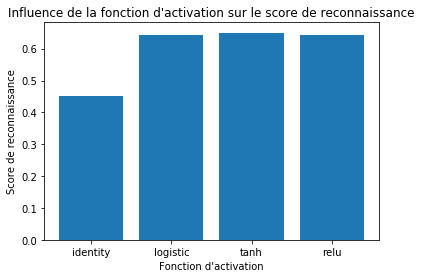

d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


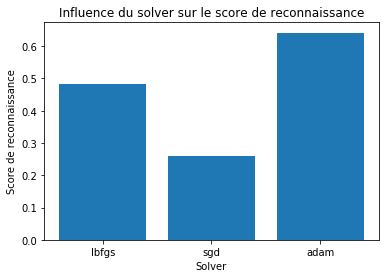

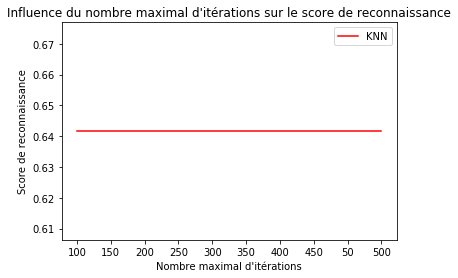

In [51]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix

list_activations = ['identity', 'logistic', 'tanh', 'relu']
list_solvers = ['lbfgs', 'sgd', 'adam']
list_maxiters = [50,100,150,200,250,300,350,400,450,500]

def comparaison_ACTIVATIONS():
    
    rates_NN = {}
    
    for activation in list_activations:
        rates_NN[activation] = rate_NN(activation=activation)

    names = list(rates_NN.keys())
    values = list(rates_NN.values())

    plt.bar(names,values)

    plt.title("Influence de la fonction d'activation sur le score de reconnaissance")
    plt.xlabel("Fonction d'activation")
    plt.ylabel("Score de reconnaissance")
    plt.show()

def comparaison_SOLVERS():
    
    rates_NN = {}
    
    for solver in list_solvers:
        rates_NN[solver] = rate_NN(solver=solver)

    names = list(rates_NN.keys())
    values = list(rates_NN.values())

    plt.bar(names,values)

    plt.title("Influence du solver sur le score de reconnaissance")
    plt.xlabel("Solver")
    plt.ylabel("Score de reconnaissance")
    plt.show()

def comparaison_MAXITERS():
    
    rates_NN = {}
    
    for n in list_maxiters:
        rates_NN[str(n)] = rate_NN(max_iter = n)

    list_NN = sorted(rates_NN.items())
    x_NN, y_NN = zip(*list_NN)

    plt.plot(x_NN,y_NN,'r-',label="KNN")

    plt.title("Influence du nombre maximal d'itérations sur le score de reconnaissance")
    plt.xlabel("Nombre maximal d'itérations")
    plt.ylabel("Score de reconnaissance")
    plt.legend()
    plt.show()
    
def analyse_conjointe():
    
    rates_NN = {}
    for i in range(15):
        for n in list_maxiters:
            for activation in list_activations:
                for solver in list_solvers:
                    rates_NN["activation = " + activation + ", solver = " + solver + ", max_iter = " + str(n)] = rate_NN(activation = activation, solver = solver, max_iter = n)
                    rates_NN = {k: v for k, v in sorted(rates_NN.items(), key=lambda item: item[1])} # on trie rates_NN par valeur
        print(list(rates_NN.keys())[-1], "score = ", list(rates_NN.values())[-1]) # on renvoie le dernier élément (celui-ci qui maximise le score de reconnaissance)

comparaison_ACTIVATIONS()
comparaison_SOLVERS()
comparaison_MAXITERS()
#analyse_conjointe()

Pour un paramètre précis (en gardant les autres paramètres par défaut), les valeurs qui optimiseraient le score de reconnaissance de notre modèle sont : 

* activation = 'logistic'

* solver = 'adam'

* max_iter = 50

Contrairement à précédemment, on effectue une analyse conjointe avec *analyse_conjointe* et on obtient les mêmes résultats :

* activation = 'logistic'

* solver = 'adam'

* max_iter = 50

Avec ces valeurs, on obtient un score de reconnaissance de $0.842$.  On a encore amélioré le modèle, celui-ci étant plus efficace que le modèle de Random Forest. Ce sont donc ces valeurs que nous retiendrons.

## 3. Ajout de nouvelles classes

Dans cette section, nous allons reprendre les versions les plus efficaces des modèles testés auparavant, puis allons étudier l'impact que l'ajout de nouvelles classes a sur leur score de reconnaissance. **Attention**, le modèle déterminé ici ne sera pas forcément optimal pour ces nouvelles classes, car on reprend les paramètres obtenus en Section 1, qui le sont pour une étude à 3 classes. L'idée ici est uniquement de déterminer l'impact qu'a ce changement sur les modèles, pas de déterminer le modèle optimal pour chaque nombre de classes.

d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


{'KNN': 0.5, 'RFC': 0.7166666666666667, 'NN': 0.65}
{'KNN': 0.5, 'RFC': 0.6666666666666666, 'NN': 0.65}
{'KNN': 0.5, 'RFC': 0.675, 'NN': 0.65}
{'KNN': 0.5, 'RFC': 0.6916666666666667, 'NN': 0.65}


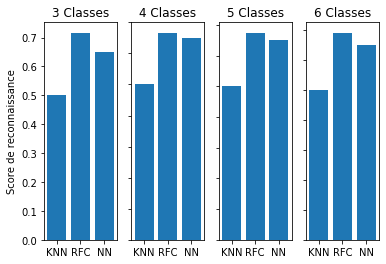

In [52]:
# Paramètres des modèles utilisés
params_KNN = [50,'distance','brute']
params_RFC = [140,'entropy',325]
params_NN = ['logistic','adam',50]

# Paramètres de traitement obtenus dans la section 1
SEGMENT_SIZE = 30
TAILLE_TEST = 80
TAILLE_APP = 40

def comparaison_classes():
    
    rates_3classes = {}
    rates_4classes = {}
    rates_5classes = {}
    rates_6classes = {}
    list_rates = [rates_3classes,rates_4classes,rates_5classes,rates_6classes]
    
    for i in range(4):
        NB_CLASSES = 3 + i
        traitement(N_CLASSES = NB_CLASSES, SEGMENT_TIME_SIZE = 30, TAILLE_TEST = 80, TAILLE_APP = 40)
        list_rates[i]["KNN"] = rate_KNN(n_neighbors=params_KNN[0], weights=params_KNN[1], algorithm=params_KNN[2])
        list_rates[i]["RFC"] = rate_RFC(n_estimators=params_RFC[0], criterion=params_RFC[1], max_depth=params_RFC[2])
        list_rates[i]["NN"] = rate_NN(activation=params_NN[0], solver=params_NN[1], max_iter=params_NN[2])
    
    names_3 = list(list_rates[0].keys())
    values_3 = list(list_rates[0].values())
    names_4 = list(list_rates[1].keys())
    values_4 = list(list_rates[1].values())
    names_5 = list(list_rates[2].keys())
    values_5 = list(list_rates[2].values())
    names_6 = list(list_rates[3].keys())
    values_6 = list(list_rates[3].values())
    
    for i in range(4):
        print(list_rates[i])

    fig, axs = plt.subplots(1, 4)
    axs[0].bar(names_3,values_3)
    axs[0].set_title("3 Classes")
    axs[1].bar(names_4,values_4)
    axs[1].set_title("4 Classes")
    axs[2].bar(names_5,values_5)
    axs[2].set_title("5 Classes")
    axs[3].bar(names_6,values_6)
    axs[3].set_title("6 Classes")

    for ax in axs.flat:
        ax.set(ylabel='Score de reconnaissance')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()

comparaison_classes()

On voit bien ici que le nombre de classes a un faible impact sur le score de reconnaissance des modèles utilisés, avec cependant de meilleurs résultats pour 3 classes.

En définitive, il semblerait que l'on doive privilégier 3 classes pour maximiser le score de reconnaissance. C'est assez pratique étant donné que toute l'analyse précédente (partie **2**) a été effectuée avec 3 classes. Ainsi, à priori, on peut dire que pour maximiser le score de reconnaissance, on devrait utiliser un RFC avec les paramètres obtenus dans la section **2.1.**

## 4. Reconnaissance d'utilisateurs

Ici, on va d'abord devoir modifier un peu le traitement afin de ne plus regrouper les données par l'activité, mais par l'utilisateur :

In [21]:
LABELS = list(data['user'].drop_duplicates().values)

In [22]:
def traitement_util(N_CLASSES = 3, N_FEATURES = 3, SEGMENT_TIME_SIZE = 30, TAILLE_TEST = 40, TAILLE_APP = 20): # Ici, on va faire varier les paramètres du modèle et étudier leur influence sur les résultats

    # Chargement DATA
    data = pd.read_csv(DATA_PATH, header=None, names=COLUMN_NAMES)
    data['z-axis'].replace({';': ''}, regex=True, inplace=True)
    data = data.dropna()


    data_convoluted = []
    labels = []



    # Prendre des segments temporels de taille SEGMENT_TIME_SIZE 
    # tous les TIME_STEP pour un même utilisateur
    for j in range(0,len(data['user'].drop_duplicates())):
        DataBest=data[data['user'] == LABELS[j]]
        for i in range(0, len(DataBest) - SEGMENT_TIME_SIZE, TIME_STEP):
            x = DataBest['x-axis'].values[i: i + SEGMENT_TIME_SIZE]
            y = DataBest['y-axis'].values[i: i + SEGMENT_TIME_SIZE]
            z = DataBest['z-axis'].values[i: i + SEGMENT_TIME_SIZE]
            data_convoluted.append([x, y, z])
        # Label de l'utilisateur associée à chaque segment
            label = j
            labels.append(label)


    # Conversion numpy
    data_convoluted = np.asarray(data_convoluted, dtype=np.float32).transpose(0, 2, 1)

    labels = np.asarray(labels, dtype=np.int)
    #print("Convoluted data shape: ", data_convoluted.shape)
    #print("Labels shape:", labels.shape)


    #fig, axs = plt.subplots(N_CLASSES,figsize=(30,30))
    #fig.suptitle('Profil moyen Activité')

    profil_median=np.zeros((N_CLASSES,SEGMENT_TIME_SIZE,N_FEATURES))
    List_Data_Test=np.zeros(N_CLASSES*TAILLE_TEST)
    Data_Test=np.zeros((N_CLASSES*TAILLE_TEST,SEGMENT_TIME_SIZE*N_FEATURES))
    Data_App=np.zeros((TAILLE_APP*N_CLASSES,SEGMENT_TIME_SIZE*N_FEATURES))
    Label_Test=np.zeros(N_CLASSES*TAILLE_TEST)
    Label_App=np.zeros(N_CLASSES*TAILLE_APP)

    for i in range(N_CLASSES):
        # Selection des données correspondant à la classe i
        #print('Classe N°',i)
        res=np.where(labels==i)
        res=np.array(res)
        res=np.ravel(res)
        taille=res.shape[0]

        # Création de la base de Test
        tirage=np.random.randint(0,taille,TAILLE_TEST)
        List_Data_Test[i*TAILLE_TEST:(i+1)*TAILLE_TEST]=res[tirage[0:TAILLE_TEST]]
        Label_Test[i*TAILLE_TEST:(i+1)*TAILLE_TEST]=i
        tir_dataTest=data_convoluted[res[tirage[0:TAILLE_TEST]],:,:]
        Data_Test[i*TAILLE_TEST:(i+1)*TAILLE_TEST,:]=np.reshape(tir_dataTest,(TAILLE_TEST,SEGMENT_TIME_SIZE*N_FEATURES))


        # Création de la base d'Apprentissage
        tirage1=np.random.randint(0,taille,TAILLE_APP)
        tir_dataApp=data_convoluted[res[tirage1[0:TAILLE_APP]],:,:]
        Data_App[i*TAILLE_APP:(i+1)*TAILLE_APP,:]=np.reshape(tir_dataApp,(TAILLE_APP,SEGMENT_TIME_SIZE*N_FEATURES))
        Label_App[i*TAILLE_APP:(i+1)*TAILLE_APP]=i

        # Affichage du profil temporel moyen de la classe
        class1=np.median(tir_dataApp,axis=0)
        profil_median[i,:,:]=class1

        #axs[i].plot(range(SEGMENT_TIME_SIZE),class1[:,0],'b--')
        #axs[i].plot(range(SEGMENT_TIME_SIZE),class1[:,1],'r-')
        #axs[i].plot(range(SEGMENT_TIME_SIZE),class1[:,2],'k.')
        #axs[i].set_ylabel('X-Y-Z acceleration (dg)',fontsize=20)
        #axs[i].set_title(LABELS[i], fontsize=20)
        
    from sklearn.decomposition import PCA

    pca = PCA(n_components = 3)
    pca.fit(Data_App)
    axes = pca.singular_values_

    New_Data_App = np.dot(Data_App.reshape(Data_App.shape[0],Data_App.shape[1]//3,3), axes.transpose())
    New_Data_Test = np.dot(Data_Test.reshape(Data_Test.shape[0],Data_Test.shape[1]//3,3), axes.transpose())

**Et c'est reparti pour un tour...**

On va donc reprendre la même analyse, mais cette fois sur de la reconnaissance d'utilisateurs.

### 4.1. Dimensionnement de la donnée

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neural_network import MLPClassifier

def rate_KNN(n_neighbors=1, weights='uniform', algorithm='auto'):

    knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, algorithm=algorithm)
    knn.fit(New_Data_App, Label_App)

    predictions = knn.predict(New_Data_Test)

    cm = confusion_matrix(predictions1, Label_Test)
    rate = (cm1ppv[0,0] + cm1ppv[1,1] + cm1ppv[2,2])/(New_Data_Test.shape[0])

    return rate

def rate_RFC(n_estimators=100, criterion='gini', max_depth=None):

    clf = RandomForestClassifier()
    clf.fit(New_Data_App, Label_App)
    preds = clf.predict(New_Data_Test)

    cmRFC = confusion_matrix(preds, Label_Test)
    rateRFC = (cmRFC[0,0] + cmRFC[1,1] + cmRFC[2,2])/(New_Data_Test.shape[0])
    return rateRFC

def rate_NN(activation='relu',solver='adam',max_iter=300):

    clf = MLPClassifier(activation=activation,solver=solver,max_iter=max_iter,random_state=1).fit(New_Data_App, Label_App)
    predictions_NN = clf.predict(New_Data_Test)

    cm_NN = confusion_matrix(predictions_NN, Label_Test)
    rate_NN = (cm_NN[0,0] + cm_NN[1,1] + cm_NN[2,2])/(New_Data_Test.shape[0])
    return rate_NN

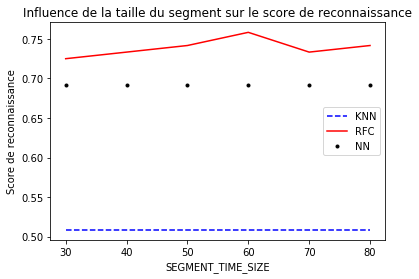

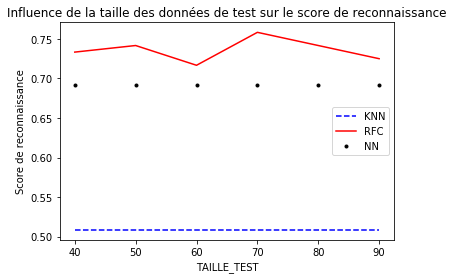

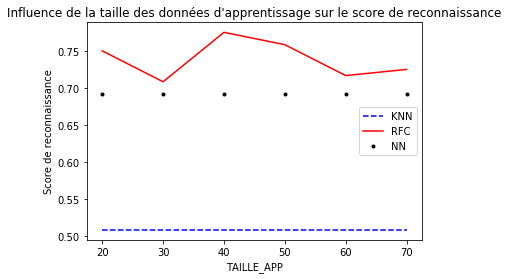

TS = 50, TT = 80, TA = 40
TS = 30, TT = 40, TA = 20
TS = 30, TT = 40, TA = 20


In [24]:
## Traitement : variation des paramètres

from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Model
#N_CLASSES = 3
#N_FEATURES = 3  # x-acceleration, y-acceleration, z-acceleration
#SEGMENT_TIME_SIZE = 30
#TAILLE_TEST=40
#TAILLE_APP=20

models = ["KNN", "RFC", "NN"]
N_MODELES = len(models) # nombre de modèles utilisés (KNN, RFC, etc...)

def comparaison_SEGMENT_SIZE():
    
    rates_KNN = {}
    rates_RFC = {}
    rates_NN = {}
    
    for i in range(6):
        traitement_util(SEGMENT_TIME_SIZE = 30 + 10*i)
        rates_KNN[str(30 + 10*i)] = rate_KNN()
        rates_RFC[str(30 + 10*i)] = rate_RFC()
        rates_NN[str(30 + 10*i)] = rate_NN()

    list_KNN = sorted(rates_KNN.items())
    list_RFC = sorted(rates_RFC.items())
    list_NN = sorted(rates_NN.items())
    x_KNN, y_KNN = zip(*list_KNN)
    x_RFC, y_RFC = zip(*list_RFC)
    x_NN, y_NN = zip(*list_NN)

    plt.plot(x_KNN,y_KNN,'b--',label="KNN")
    plt.plot(x_RFC,y_RFC,'r-',label="RFC")
    plt.plot(x_NN,y_NN,'k.',label="NN")

    plt.title('Influence de la taille du segment sur le score de reconnaissance')
    plt.xlabel("SEGMENT_TIME_SIZE")
    plt.ylabel("Score de reconnaissance")
    plt.legend()
    plt.show()
    
def comparaison_TAILLE_TEST():
    
    rates_KNN = {}
    rates_RFC = {}
    rates_NN = {}
    
    for i in range(6):
        traitement_util(TAILLE_TEST = 40 + 10*i)
        rates_KNN[str(40 + 10*i)] = rate_KNN()
        rates_RFC[str(40 + 10*i)] = rate_RFC()
        rates_NN[str(40 + 10*i)] = rate_NN()

    list_KNN = sorted(rates_KNN.items())
    list_RFC = sorted(rates_RFC.items())
    list_NN = sorted(rates_NN.items())
    x_KNN, y_KNN = zip(*list_KNN)
    x_RFC, y_RFC = zip(*list_RFC)
    x_NN, y_NN = zip(*list_NN)

    plt.plot(x_KNN,y_KNN,'b--',label="KNN")
    plt.plot(x_RFC,y_RFC,'r-',label="RFC")
    plt.plot(x_NN,y_NN,'k.',label="NN")

    plt.title('Influence de la taille des données de test sur le score de reconnaissance')
    plt.xlabel("TAILLE_TEST")
    plt.ylabel("Score de reconnaissance")
    plt.legend()
    plt.show()
    
def comparaison_TAILLE_APP():
    
    rates_KNN = {}
    rates_RFC = {}
    rates_NN = {}
    
    for i in range(6):
        traitement_util(TAILLE_APP = 20 + 10*i)
        rates_KNN[str(20 + 10*i)] = rate_KNN()
        rates_RFC[str(20 + 10*i)] = rate_RFC()
        rates_NN[str(20 + 10*i)] = rate_NN()

    list_KNN = sorted(rates_KNN.items())
    list_RFC = sorted(rates_RFC.items())
    list_NN = sorted(rates_NN.items())
    x_KNN, y_KNN = zip(*list_KNN)
    x_RFC, y_RFC = zip(*list_RFC)
    x_NN, y_NN = zip(*list_NN)

    plt.plot(x_KNN,y_KNN,'b--',label="KNN")
    plt.plot(x_RFC,y_RFC,'r-',label="RFC")
    plt.plot(x_NN,y_NN,'k.',label="NN")

    plt.title("Influence de la taille des données d'apprentissage sur le score de reconnaissance")
    plt.xlabel("TAILLE_APP")
    plt.ylabel("Score de reconnaissance")
    plt.legend()
    plt.show()
    
def comparaison_globale():
    
    rates_KNN = {}
    rates_RFC = {}
    rates_NN = {}
    
    for i in range(6):
        time_size = 30 + 10*i
        for j in range(6):
            taille_test = 40 + 10*i
            for k in range(6):
                taille_app = 20 + 10*i
                traitement_util(SEGMENT_TIME_SIZE = time_size, TAILLE_TEST = taille_test, TAILLE_APP = taille_app)
                rates_KNN["TS = " + str(30 + 10*i) + ", TT = " + str(40 + 10*j) + ", TA = " + str(20 + 10*k)] = rate_KNN()
                rates_RFC["TS = " + str(30 + 10*i) + ", TT = " + str(40 + 10*j) + ", TA = " + str(20 + 10*k)] = rate_RFC()
                rates_NN["TS = " + str(30 + 10*i) + ", TT = " + str(40 + 10*j) + ", TA = " + str(20 + 10*k)] = rate_NN()
    
    print(list(rates_RFC.keys())[list(rates_RFC.values()).index(max(rates_RFC.values()))])
    print(list(rates_KNN.keys())[list(rates_KNN.values()).index(max(rates_KNN.values()))])
    print(list(rates_NN.keys())[list(rates_NN.values()).index(max(rates_NN.values()))])
    
    
    
    
comparaison_SEGMENT_SIZE()
comparaison_TAILLE_TEST()
comparaison_TAILLE_APP()
#comparaison_globale()

Comme ces paramètres ne font pas varier le KNN et le NN, les valeurs optimales obtenues sont ici :

SEGMENT_SIZE = 50

TAILLE_TEST = 80

TAILLE_APP = 40

Pour ces valeurs, le score de reconnaissance atteint 0.77.

### 4.2. Comparaison des différents modèles ###

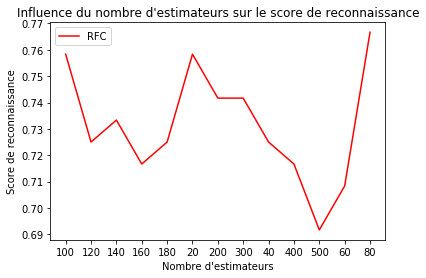

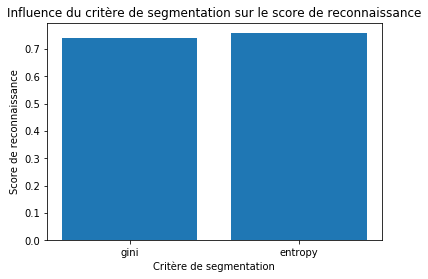

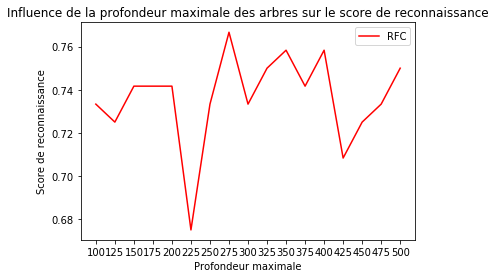

n_estimators = 160, criterion = gini, max_depth = 350 
score = 
 0.8083333333333333


In [25]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix

traitement_util(SEGMENT_TIME_SIZE = 60, TAILLE_TEST = 60, TAILLE_APP = 50)
list_estimators = [20,40,60,80,100,120,140,160,180,200,300,400,500]
list_criterions = ['gini','entropy']
list_depths = range(100,501,25)

def comparaison_ESTIMATORS():
    
    rates_RFC = {}
    
    for n in list_estimators:
        rates_RFC[str(n)] = rate_RFC(n_estimators = n)

    list_RFC = sorted(rates_RFC.items())
    x_RFC, y_RFC = zip(*list_RFC)

    plt.plot(x_RFC,y_RFC,'r-',label="RFC")

    plt.title("Influence du nombre d'estimateurs sur le score de reconnaissance")
    plt.xlabel("Nombre d'estimateurs")
    plt.ylabel("Score de reconnaissance")
    plt.legend()
    plt.show()

def comparaison_CRITERIONS():
    
    rates_RFC = {}
    
    for criterion in list_criterions:
        rates_RFC[criterion] = rate_RFC(criterion = criterion)

    names = list(rates_RFC.keys())
    values = list(rates_RFC.values())

    plt.bar(names,values)

    plt.title("Influence du critère de segmentation sur le score de reconnaissance")
    plt.xlabel("Critère de segmentation")
    plt.ylabel("Score de reconnaissance")
    plt.show()
    
def comparaison_DEPTHS():
    
    rates_RFC = {}
    
    for depth in list_depths:
        rates_RFC[str(depth)] = rate_RFC(max_depth = depth)

    list_RFC = sorted(rates_RFC.items())
    x_RFC, y_RFC = zip(*list_RFC)

    plt.plot(x_RFC,y_RFC,'r-',label="RFC")

    plt.title("Influence de la profondeur maximale des arbres sur le score de reconnaissance")
    plt.xlabel("Profondeur maximale")
    plt.ylabel("Score de reconnaissance")
    plt.legend()
    plt.show()
    
def analyse_conjointe():
    
    rates_RFC = {}
    
    for n in list_estimators:
        for criterion in list_criterions:
            for depth in list_depths:
                rates_RFC["n_estimators = " + str(n) + ", criterion = " + criterion + ", max_depth = " + str(depth)] = rate_RFC(n_estimators = n, criterion = criterion, max_depth = depth)
                rates_RFC = {k: v for k, v in sorted(rates_RFC.items(), key=lambda item: item[1])} # on trie rates_RFC par valeur
    print(list(rates_RFC.keys())[-1], "\nscore = \n", list(rates_RFC.values())[-1]) # on renvoie le dernier élément (celui-ci qui maximise le score de reconnaissance)

comparaison_ESTIMATORS()
comparaison_CRITERIONS()
comparaison_DEPTHS()
analyse_conjointe()

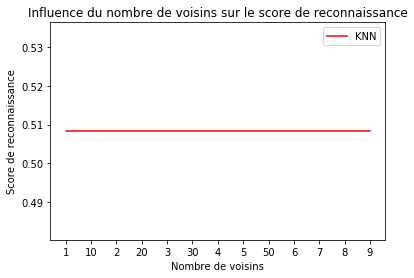

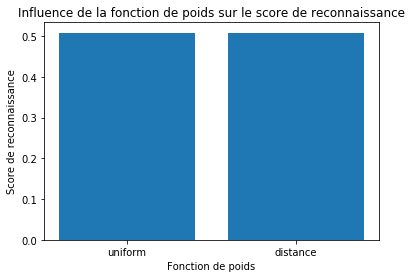

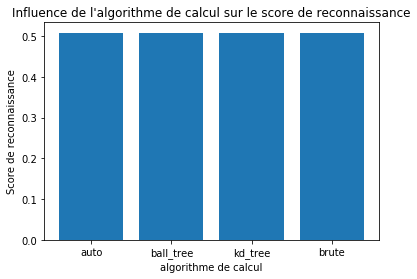

n_neighbors = 50, weights = distance, algorithm = brute 
score = 
 0.5083333333333333


In [26]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix

list_neighbors = [1,2,3,4,5,6,7,8,9,10,20,30,50]
list_weights = ['uniform', 'distance']
list_algorithms = ['auto', 'ball_tree', 'kd_tree', 'brute']

def comparaison_NEIGHBORS():
    
    rates_KNN = {}
    
    for n in list_neighbors:
        rates_KNN[str(n)] = rate_KNN(n_neighbors = n)

    list_KNN = sorted(rates_KNN.items())
    x_KNN, y_KNN = zip(*list_KNN)

    plt.plot(x_KNN,y_KNN,'r-',label="KNN")

    plt.title("Influence du nombre de voisins sur le score de reconnaissance")
    plt.xlabel("Nombre de voisins")
    plt.ylabel("Score de reconnaissance")
    plt.legend()
    plt.show()

def comparaison_WEIGHTS():
    
    rates_KNN = {}
    
    for weight in list_weights:
        rates_KNN[weight] = rate_KNN(weights = weight)

    names = list(rates_KNN.keys())
    values = list(rates_KNN.values())

    plt.bar(names,values)

    plt.title("Influence de la fonction de poids sur le score de reconnaissance")
    plt.xlabel("Fonction de poids")
    plt.ylabel("Score de reconnaissance")
    plt.show()
    
def comparaison_ALGORITHMS():
    
    rates_KNN = {}
    
    for algo in list_algorithms:
        rates_KNN[str(algo)] = rate_KNN(algorithm = algo)

    names = list(rates_KNN.keys())
    values = list(rates_KNN.values())

    plt.bar(names,values)

    plt.title("Influence de l'algorithme de calcul sur le score de reconnaissance")
    plt.xlabel("algorithme de calcul")
    plt.ylabel("Score de reconnaissance")
    plt.show()
    
def analyse_conjointe():
    
    rates_KNN = {}
    for i in range(5):
        for n in list_neighbors:
            for weight in list_weights:
                for algo in list_algorithms:
                    rates_KNN["n_neighbors = " + str(n) + ", weights = " + weight + ", algorithm = " + algo] = rate_KNN(n_neighbors = n, weights = weight, algorithm = algo)
                    rates_KNN = {k: v for k, v in sorted(rates_KNN.items(), key=lambda item: item[1])} # on trie rates_KNN par valeur
    print(list(rates_KNN.keys())[-1], "\nscore = \n", list(rates_KNN.values())[-1]) # on renvoie le dernier élément (celui-ci qui maximise le score de reconnaissance)

comparaison_NEIGHBORS()
comparaison_WEIGHTS()
comparaison_ALGORITHMS()
analyse_conjointe()

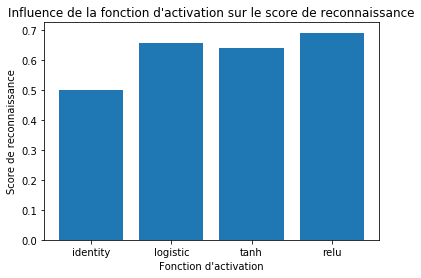

d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


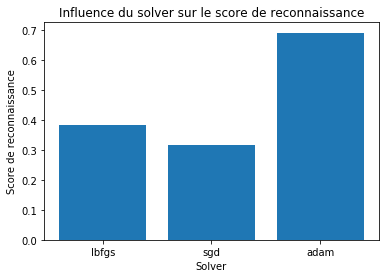

d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


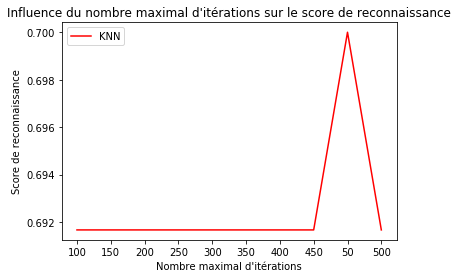

d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs",

d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, se

d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (stat

d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, se

d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to

d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, se

d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Opti

d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Converg

d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (st

d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, Converge

d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs"

d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (stat

d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, se

d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to

d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, se

d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  % self.max_

d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (450) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, se

d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.or

d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, se

d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_

d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to c

d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs"

d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, sel

d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, se

d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to

d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, se

d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  % self.max_

d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (450) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, se

activation = relu, solver = adam, max_iter = 50 score =  0.7


d:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [27]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix

list_activations = ['identity', 'logistic', 'tanh', 'relu']
list_solvers = ['lbfgs', 'sgd', 'adam']
list_maxiters = [50,100,150,200,250,300,350,400,450,500]

def comparaison_ACTIVATIONS():
    
    rates_NN = {}
    
    for activation in list_activations:
        rates_NN[activation] = rate_NN(activation=activation)

    names = list(rates_NN.keys())
    values = list(rates_NN.values())

    plt.bar(names,values)

    plt.title("Influence de la fonction d'activation sur le score de reconnaissance")
    plt.xlabel("Fonction d'activation")
    plt.ylabel("Score de reconnaissance")
    plt.show()

def comparaison_SOLVERS():
    
    rates_NN = {}
    
    for solver in list_solvers:
        rates_NN[solver] = rate_NN(solver=solver)

    names = list(rates_NN.keys())
    values = list(rates_NN.values())

    plt.bar(names,values)

    plt.title("Influence du solver sur le score de reconnaissance")
    plt.xlabel("Solver")
    plt.ylabel("Score de reconnaissance")
    plt.show()

def comparaison_MAXITERS():
    
    rates_NN = {}
    
    for n in list_maxiters:
        rates_NN[str(n)] = rate_NN(max_iter = n)

    list_NN = sorted(rates_NN.items())
    x_NN, y_NN = zip(*list_NN)

    plt.plot(x_NN,y_NN,'r-',label="KNN")

    plt.title("Influence du nombre maximal d'itérations sur le score de reconnaissance")
    plt.xlabel("Nombre maximal d'itérations")
    plt.ylabel("Score de reconnaissance")
    plt.legend()
    plt.show()
    
def analyse_conjointe():
    
    rates_NN = {}
    for i in range(15):
        for n in list_maxiters:
            for activation in list_activations:
                for solver in list_solvers:
                    rates_NN["activation = " + activation + ", solver = " + solver + ", max_iter = " + str(n)] = rate_NN(activation = activation, solver = solver, max_iter = n)
                    rates_NN = {k: v for k, v in sorted(rates_NN.items(), key=lambda item: item[1])} # on trie rates_NN par valeur
    print(list(rates_NN.keys())[-1], "score = ", list(rates_NN.values())[-1]) # on renvoie le dernier élément (celui-ci qui maximise le score de reconnaissance)

comparaison_ACTIVATIONS()
comparaison_SOLVERS()
comparaison_MAXITERS()
analyse_conjointe()


On obtient les résultats suivants : 
* **RFC** : *n_estimators* = 150, *criterion* = gini, *max_depth* = 350 => accuracy = 0.81
* **KNN** : *n_neighbors* = 50, *weights* = distance, *algorithm* = brute => accuracy = 0.51
* **MLP** : *activation* = relu, *solver* = adam, *max_iter* = 50 => accuracy = 0.7